# Codificadore Automáticos com Fashion MNIST

O autoencoder é um tipo especial de rede neural treinada para codificar e compactar informações em um modelo latente que é construido a partir de uma entrada. Com esse modelo latente definido, é possivel decodifica-lo com o objetivo de se ter uma saída o mais parecido possível com a entrada.

Para o estudo de caso a seguir, será utilizado um conjunto de dados de imagens de roupas em escalas de cinza para construir um modelo latente capaz de reproduzir sua entrada e de retirar possíveis ruídos que a acompanhem.

## Importação do tensorflow e da demais bibliotecas

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## Carregamento do conjunto de dados
Para começar, será necessário carregar o conjunto de dados e separa-los entre aqueles que serão usado para treinamento e aqueles que serão usado para teste.



In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


# 1º Parte - Contrução do modelo do codificador automático e compilação
Nesta primeira parte, começaremos criando o modelo com duas camadas de rede Dense: a primeira para codificar e compactar o conjunto de dados em um modelo latente e a segunda para decodificar esse modelo com o objetivo de reconstruir os dados compactados.

O modelo é então compilado usando o otimizador "adam" e as perdas são analisadas utilizando como parâmetro a perda média quadrática.

In [3]:
latent_dim = 392

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(), #784
      layers.Dense(latent_dim, activation='relu'), #array de 64
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder = Autoencoder(latent_dim) 

In [4]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

# Treinamento do modelo
O modelo é então treinado e validado, utilizando parte do conjunto de dados originais para o treinamento e parte para a validação.

In [5]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 10s 3ms/step - loss: 0.0144 - val_loss: 0.0066
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0053 - val_loss: 0.0044
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 4/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 6/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 8/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.00

# Teste do modelo
Agora que o modelo está treinado, vamos testá-lo codificando e decodificando imagens do conjunto de teste.

In [6]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
encoded_imgs.shape

decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
decoded_imgs.shape

print(encoded_imgs.shape)
print(decoded_imgs.shape)

(10000, 392)
(10000, 28, 28)


# Reconstrução das imagens
Então, as imagens são reconstruidas para comparar a capacidade do modelo latente em reconstruir sua própria entrada.


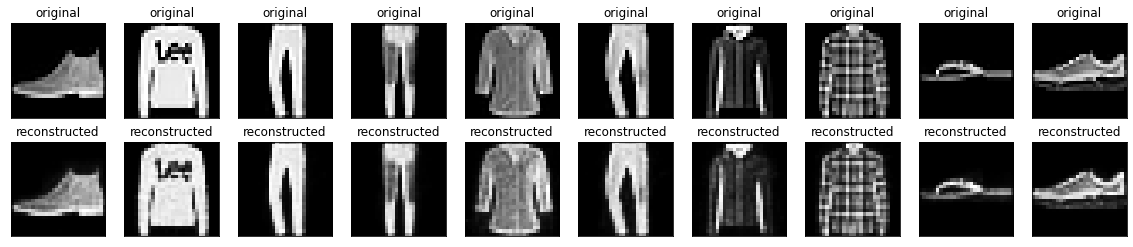

In [8]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# Conclusão da primeira parte
A partir do modelo latente foi possível reconstruir sua entrada original sem grandes perdas. Para o conjunto de dados em questão, seria possível diminuir ainda mais a dimensão do espaço latente e ainda sim ser possível realizar uma decodificação que tenha como saída imagens bem parecidas com as originais. Importante ressaltar que isso se deve pelo fato das imagens serem de baixa resolução. Dessa forma, quanto maior a resolução das imagens do conjunto de dados, menos compactadas elas poderão ser sem que ocorram grandes perdas de resolução em sua decodificação.

# 2º Parte - Remoção de ruídos a partir de redes convolucionais
Para esta segunda parte, serão utilizadas redes neurais convolucionais como filtro para retirar ruídos das imagens. Para simular esses possíveis ruídos, a forma original do conjunto de dados será alterada utilizando modificações que seguem o padrão da distribuição normal definida pela função gaussiana.

Os dados originais serão carregados novamentes, porém desta vez será acrescido a base de treinamento e teste uma nova dimensão para se poder aplicar as redes neurais convolucionais.

In [10]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


# Alteração do conjunto de dados
A base é então alterada para simular a presença de ruídos. Essas modificações serão de acordo com o modelo Gaussiano da distribuição normal.

In [11]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

# Imagens alteradas
Com o intuito de se ver as mudanças provocadas pela inserção desses ruídos artificais as novas imagens são traçadas.

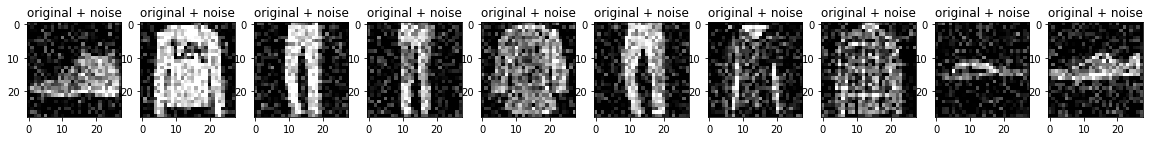

In [12]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

# Contrução do modelo do convolucional para codificação e decodificação
O modelo para esta segunda parte é então criado: serão usadas duas camadas de rede convolucional para a codificação e compactação do conjunto de dados com ruidos - e duas camadas de rede convolucional para decodificação com o objetivo de recriar o conjunto de dados só que sem os ruídos que foram artificialmente inseridos.

O modelo é então compilado usando o otimizador "adam" e as perdas são analisadas utilizando como parâmetro a perda média quadrática.

In [13]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)), 
      layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3,3), activation='relu', padding='same', strides=2)])
    
    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [14]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

# Treinamento do modelo
O modelo é então treinado e validado, utilizando parte do conjunto de dados com ruído para o treinamento e parte para a validação.

In [16]:
autoencoder.fit(x_train_noisy, x_train, # X, y
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0164 - val_loss: 0.0096
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0089 - val_loss: 0.0084
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0081 - val_loss: 0.0079
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0073 - val_loss: 0.0072
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.006

#Análise do resumo do codificador e do decodificador
Analisando o sumário do codificador e do decodificador podemos notar que o modelo foi capaz de reduzir as dimensões do conjunto de dados de entrada para uma forma mais compacta e que o decodificador conseguiu restaurar as dimensões originais dos dados inseridos.

Enquanto o codificador conseguiu reduzir as dimensões de (28 x 28) para (7 x 7), o decodificador conseguiu aumentar a amostragens das imagens de (7 x 7) para (28 x 28).

In [17]:
autoencoder.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [18]:
autoencoder.decoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 14, 14, 8)        584       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


# Reconstrução das imagens
Agora, as imagens são reconstruidas para se avaliar se o modelo foi capaz de retirar os ruídos inseridos por meio da utilização das redes neurais convolucionais.


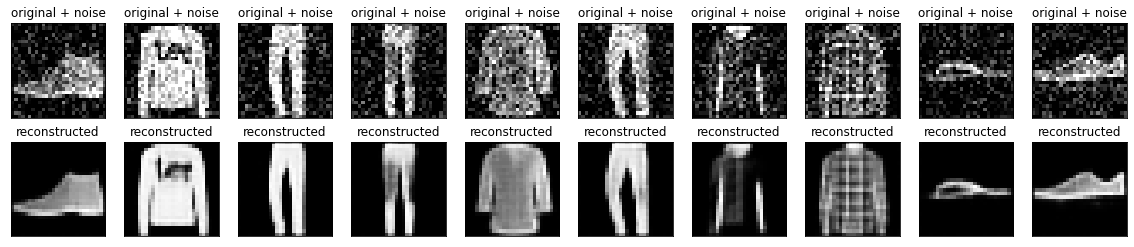

In [20]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

# Conclusão da segunda parte
A partir do uso das redes neurais convolucionais foi possível se treinar um modelo capaz de retirar os ruídos atribuidos inicialmente, mesmo utilizando uma base de treinamento e de validação com ruídos.